#### Door Keeper

In [1]:
import torch
import numpy as np
import open3d as o3d
import torch.nn.functional as F
import torch.nn as nn
import math
import os
import cv2
import matplotlib.pylab as plt


from pyhocon import ConfigFactory

from models.fields import FeatureField, SDFNetwork
from reconstruct.optimizer import Optimizer
from reconstruct.utils import color_table, set_view, get_configs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_checkpoint(checkpoint_fname):
    # read network config
    conf_path = './confs/wmask.conf'
    f = open(conf_path)
    conf_text = f.read()
    conf_text = conf_text.replace('CASE_NAME', 'owl') #TODO case name as input
    f.close()
    conf = ConfigFactory.parse_string(conf_text)

    # load feature field
    checkpoint = torch.load(os.path.join(checkpoint_fname), map_location='cuda')
    sdf_network = SDFNetwork(**conf['model.sdf_network']).to(device)
    # feature_network = FeatureField(**conf['model.feature_field']).to('cuda')
    # self.nerf_outside.load_state_dict(checkpoint['nerf'])
    sdf_network.load_state_dict(checkpoint['sdf_network_fine'])
    # self.deviation_network.load_state_dict(checkpoint['variance_network_fine'])
    # self.color_network.load_state_dict(checkpoint['color_network_fine'])
    # feature_network.load_state_dict(checkpoint['feature_network'])
    # self.optimizer_geometry.load_state_dict(checkpoint['optimizer-geometry'])
    # self.optimizer_feature.load_state_dict(checkpoint['optimizer-feature'])

    # iter_step = checkpoint['iter_step']
    print(f"loaded checkpoint from {checkpoint_fname}")
    return sdf_network

# helper function for pointcloud
def visualize_points(points, colors=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

def visualize_point_cloud(pcd):
    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])

class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud"""

    def __init__(self, height, width):
        super(BackprojectDepth, self).__init__()

        # self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing="xy")
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(
            torch.from_numpy(self.id_coords), requires_grad=False
        )
        self.pix_coords = torch.unsqueeze(
            torch.stack([self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0
        )

    def forward(self, depth, K):
        if isinstance(K, np.ndarray):
            assert K.shape == (3, 3)
            K = torch.from_numpy(K).float().to(depth.device)[None]

        batch_size = depth.shape[0]
        ones = torch.ones(batch_size, 1, self.height * self.width).to(depth.device)
        inv_K = torch.inverse(K).to(depth.device)  # [B, 3, 3]

        pix_coords = self.pix_coords.clone().to(depth.device)
        pix_coords = pix_coords.repeat(batch_size, 1, 1)
        pix_coords = torch.cat([pix_coords, ones], 1)  # [B, 3, H*W]

        cam_points = torch.matmul(inv_K, pix_coords)  # [B, 3, 3] @ [B, 3, H*W]
        cam_points = (
            depth.view(batch_size, 1, -1) * cam_points
        )  # [B, 1, H*W] * [B, 3, H*W]
        return cam_points

def backproject(depth, intrinsics, instance_mask, NOCS_convention=True):
    intrinsics_inv = np.linalg.inv(intrinsics)
    # image_shape = depth.shape
    # width = image_shape[1]
    # height = image_shape[0]

    # x = np.arange(width)
    # y = np.arange(height)

    # non_zero_mask = np.logical_and(depth > 0, depth < 5000)
    non_zero_mask = depth > 0
    final_instance_mask = np.logical_and(instance_mask, non_zero_mask)

    idxs = np.where(final_instance_mask)
    grid = np.array([idxs[1], idxs[0]])

    # shape: height * width
    # mesh_grid = np.meshgrid(x, y) #[height, width, 2]
    # mesh_grid = np.reshape(mesh_grid, [2, -1])
    length = grid.shape[1]
    ones = np.ones([1, length])
    uv_grid = np.concatenate((grid, ones), axis=0)  # [3, num_pixel]

    xyz = intrinsics_inv @ uv_grid  # [3, num_pixsel]
    xyz = np.transpose(xyz)  # [num_pixel, 3]

    z = depth[idxs[0], idxs[1]]

    # print(np.amax(z), np.amin(z))
    pts = xyz * z[:, np.newaxis] / xyz[:, -1:]
    if NOCS_convention:
        pts[:, 1] = -pts[:, 1]
        pts[:, 2] = -pts[:, 2]
    return pts, idxs


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### load checkpoint and SDF

In [2]:
obj_name = 'owl'
ckpt_path = './exp/neus/'+ obj_name +'/checkpoints/ckpt_005000.pth'
print(ckpt_path)
config_path = './confs/optimizer.json' # into args
configs = get_configs(config_path)

sdf_network = load_checkpoint(ckpt_path)

./exp/neus/cup_hz/checkpoints/ckpt_003000.pth
loaded checkpoint from ./exp/neus/cup_hz/checkpoints/ckpt_003000.pth


(256, 256)
0.9596455841064453


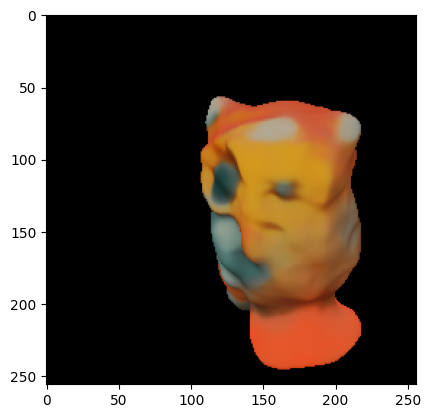

In [35]:
dataset_path = './data/pose_estimation/'
frame_idx = 16
# image file name
rgb_image_path = os.path.join(dataset_path, 'rgbsyn_init_calib/{:06d}.png'.format(frame_idx))
depth_image_path = os.path.join(dataset_path, 'depth_init_calib/{:06d}.png'.format(frame_idx))

# read image
rgba_image = cv2.imread(rgb_image_path, -1)
rgb_image = rgba_image[..., :3][..., [2,1,0]]
mask_image = rgba_image[..., 3]
depth_img = cv2.imread(depth_image_path, -1) / 1000
print(depth_img.shape)
print(depth_img.mean())

camera_config_path = os.path.join(dataset_path, 'camera_info.json')
camera_config = get_configs(camera_config_path)

camera_intrinsic = np.array(camera_config[str(frame_idx)]["cam_intrinsic"])

R_co = np.array(camera_config[str(frame_idx)]["cam_R_m2c"])
t_co = np.array(camera_config[str(frame_idx)]["cam_t_m2c"])
T_co = np.eye(4)
T_co[:3,:3] = R_co
T_co[:3,3] = t_co

# image to pointcloud 
# pts = rgbd_to_point_cloud(rgb_img,depth_img,camera_intrinsic)
plt.imshow(rgb_image)

## Test Mesh and Pointcloud
transfer mesh from {object} to {camera}

In [33]:
points, _ = backproject(depth_img, camera_intrinsic, depth_img>0, NOCS_convention=False)
print(points.shape)
print(points[:10,:])

mesh_path = os.path.join(dataset_path, 'owl.ply')
mesh = o3d.io.read_triangle_mesh(mesh_path)
# o3d.visualization.draw_geometries([mesh])


axis = o3d.geometry.TriangleMesh.create_coordinate_frame(1)

T_oc = np.linalg.inv(T_co)
points_in_obj = points @ T_oc[:3, :3].T + T_oc[:3, 3]

### Batching
points_pt = torch.from_numpy(points)[None].repeat(4, 1, 1).float()
T_oc_pt = torch.from_numpy(T_oc)[None].repeat(4, 1, 1).float()
print(points_pt.shape, T_oc_pt.shape, T_oc_pt[..., :3, 3].shape)
points_in_obj_pt = torch.matmul(points_pt, T_oc_pt[..., :3, :3].transpose(-1, -2)) + T_oc_pt[..., :3, 3].unsqueeze(-2)


pcd = visualize_points(points_in_obj)


print(mesh.get_center())
print(f'pcd dimension:{pcd.get_min_bound()}, {pcd.get_max_bound()}')
print(f'mesh dimension:{mesh.get_min_bound()}, {mesh.get_max_bound()}')


o3d.visualization.draw_geometries([mesh,pcd,axis])
# o3d.visualization.draw_geometries([pcd])


(16768, 3)
[[-0.39785447 -0.79303917  3.968     ]
 [-0.38778961 -0.79044101  3.955     ]
 [-0.37854902 -0.78944172  3.95      ]
 [-0.36961145 -0.789042    3.948     ]
 [-0.36095695 -0.78924186  3.949     ]
 [-0.35310073 -0.79124044  3.959     ]
 [-0.4151208  -0.78383071  3.965     ]
 [-0.40480002 -0.78086539  3.95      ]
 [-0.3951473  -0.77908621  3.941     ]
 [-0.3858286  -0.77790008  3.935     ]]
torch.Size([4, 16768, 3]) torch.Size([4, 4, 4]) torch.Size([4, 3])
[ 0.01010223  0.04076823 -0.05212489]
pcd dimension:[-0.49143091 -0.72176211 -0.69059391], [0.48832831 0.65777602 0.70453846]
mesh dimension:[-0.49126613 -0.7254535  -0.78762269], [0.50331885 0.67995405 0.70241767]


In [52]:
# optional method
# depth_img = np.array(depth_img)/1000
# points_scene, scene_idx = backproject(
#                 depth_img,
#                 camera_intrinsic,
#                 depth_img < 10,
#                 NOCS_convention=False,
#             )

# # colors_scene = color[scene_idx[0], scene_idx[1]]
# pcd_scene = visualize_points(points_scene)

# o3d.visualization.draw_geometries([pcd_scene])

## Visualize Camera Views

In [41]:
# cam_pose_dir = "./models/fixed_poses/" # NeuS fixed poses   
cam_pose_dir = "/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses" # instant-nsr-pl fixed poses


# Get all file names in the directory
file_names = os.listdir(cam_pose_dir)

# Create a list to store the file paths
file_paths = []

# Iterate over the file names
for file_name in file_names:
    # Check if the file is a text file
    if file_name.endswith(".txt"):
        # Construct the file path by joining the directory path and file name
        file_path = os.path.join(cam_pose_dir, file_name)
        # Append the file path to the list
        file_paths.append(file_path)

# Print the resulting array
print(file_paths)

# Initialize an empty list to store the data
poses = []
# Read data from each file
for file_path in file_paths:
    pose = np.loadtxt(file_path).reshape(3, 4)
    pose = np.vstack([pose,[0,0,0,1]])
    poses.append(pose)

# Print the resulting array
print(poses[0].shape) # T_co

['/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_left_RT.txt', '/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_RT.txt', '/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_right_RT.txt', '/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_top_RT.txt', '/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_right_RT.txt', '/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_back_RT.txt', '/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_back_right_RT.txt', '/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_left_RT.txt', '/home/stud/zanr/code/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_back_left_RT.txt']
(4, 4)


In [43]:
dataset_path = './data/pose_estimation/'
# mesh_path = os.path.join(dataset_path, 'owl.ply')
# mesh_path = os.path.join('./exp/neus/bowl1/meshes/bowl1_5377.glb')
# mesh_path = os.path.join('/home/stud/zanr/code/Wonder3D/NeuS/exp/neus/owl/meshes/tmp.glb') # 
# mesh_path = os.path.join('/home/stud/zanr/code/Wonder3D/instant-nsr-pl/exp/owl/@20240807-143122/save/it3000-mc192.obj') # owl instant trained with instant fixed pose

# mesh_path = os.path.join('/home/stud/zanr/code/Wonder3D/NeuS/exp/neus/owl/meshes/tmp.glb')  # owl NeuS trained with instant fixed pose
# mesh_path = os.path.join('/home/stud/zanr/code/Wonder3D/NeuS/exp/neus/owl_backup.glb') # owl NeuS trained with NeuS fixed pose
mesh_path = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/exp/neus/cup_hz/meshes/cup_hz_3000.glb'
mesh_path = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/exp/neus/object_rgba_0/meshes/object_rgba_0_3000.glb'



mesh = o3d.io.read_triangle_mesh(mesh_path)

def draw_cameras(poses, mesh):
    line_sets = []
    for pose in poses:
        
        T_oc = np.linalg.inv(pose)  
        # Create camera frustum
        width = -0.1
        height = -0.1
        depth = -0.1
        camera_points = mesh.get_center() + np.array([[0, 0, 0], [width, height, depth], [width, -height, depth], [-width, -height, depth], [-width, height, depth]]) # 5 points for frustum
        camera_points = camera_points @ T_oc[:3, :3].T + T_oc[:3, 3]

        # Create camera frustum mesh
        lines = [[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [2, 3], [3, 4], [4, 1]]
        colors = [[1, 0, 0] for _ in range(len(lines))]
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(camera_points)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector(colors)
        line_sets.append(line_set)

    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(1) # world frame 
    # mesh.coordinate_frame

    # Visualize the rotated mesh and the coordinate frame
    # o3d.visualization.draw_geometries([mesh, coordinate_frame])
    o3d.visualization.draw_geometries([mesh, axis] + line_sets)

# Example cam_K
draw_cameras(poses, mesh)

In [34]:
# create a 2d pixel grid 
W = 256
H = 256
tx = torch.linspace(0, W - 1, W)
ty = torch.linspace(0, H - 1, H)
pixels_x, pixels_y = torch.meshgrid(tx, ty)
print(pixels_x.shape, pixels_y.shape) # 255x255

pixels_x = pixels_x.reshape(-1).long()
pixels_y = pixels_y.reshape(-1).long()

print(pixels_x.shape, pixels_y.shape)
# color = self.images[img_idx][(pixels_y, pixels_x)]    # batch_size, 3 -> 4 
# mask = self.masks[img_idx][(pixels_y, pixels_x)]      # batch_size, 3
# features = self.features[img_idx][((pixels_y, pixels_x))].to('cpu') # batch_size 1
# normal = self.normals_world[img_idx][(pixels_y, pixels_x)]      # batch_size, 3

# # q the center of the image plane
# q = torch.stack([(pixels_x / self.W-0.5)*2, (pixels_y / self.H-0.5)*2, torch.zeros_like(pixels_y)], dim=-1).float()  # batch_size, 3
# v = torch.stack([torch.zeros_like(pixels_y), torch.zeros_like(pixels_y), torch.ones_like(pixels_y)], dim=-1).float() # 001 z-axis
        

torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([65536]) torch.Size([65536])


## Test SDF: 
here the pointcloud in {camera} should be transferred into {object} frame 

In [49]:
n = 10
ones = np.ones((n, 1))

def random_select(n,pts):
    random_idx = np.random.randint(0,pts.shape[0],size=(n,))
    return pts[random_idx]

points_random = points_in_obj.copy() + np.random.rand(len(points_in_obj), 3) * 10

sdf_on_surf = sdf_network.sdf(torch.tensor(points_in_obj).to(device).to(torch.float))
sdf_on_free = sdf_network.sdf(torch.tensor(points_random).to(device).to(torch.float))
sdf_on_surf_batch = sdf_network.sdf(points_in_obj_pt.view(-1, 3).to(device)).to(torch.float)
print(sdf_on_surf.mean())
print(sdf_on_free)
print(sdf_on_surf_batch.mean())

tensor(-0.0030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[4.4007],
        [2.3782],
        [2.1689],
        ...,
        [2.4318],
        [2.3410],
        [3.6274]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(-0.0030, device='cuda:0', grad_fn=<MeanBackward0>)


# Test with Cup_HZ

In [6]:
obj_name = 'cup_hz'
ckpt_path = './exp/neus/'+ obj_name +'/checkpoints/ckpt_003000.pth'
print(ckpt_path)
config_path = './confs/optimizer.json' # into args
configs = get_configs(config_path)

sdf_network = load_checkpoint(ckpt_path)
# mesh_path = '/home/stud/zanr/code/tmp/Wonder3D/customized_data/2023-12-05-17-44-48/object_pose/object.obj'
mesh_path = f'/home/stud/zanr/code/tmp/Wonder3D/NeuS/exp/neus/{obj_name}/meshes/{obj_name}_3000.glb'

mesh = o3d.io.read_triangle_mesh(mesh_path)
axis = o3d.geometry.TriangleMesh.create_coordinate_frame(1)

./exp/neus/cup_hz/checkpoints/ckpt_003000.pth
loaded checkpoint from ./exp/neus/cup_hz/checkpoints/ckpt_003000.pth


In [7]:
dataset_path = '../customized_data/cup_hz/'
rgb_image_path = os.path.join(dataset_path, 'object_rgba.png')
# depth_image_path = os.path.join(dataset_path, 'object_depth.png')
mask_image_path = os.path.join(dataset_path, 'object_pose/0_mask.png')
print(mask_image_path)
depth_image_path = os.path.join(dataset_path, 'depth/000001.png')
# depth_image_path = '/home/stud/zanr/code/tmp/Wonder3D/customized_data/2023-12-05-17-44-48/object_depth_test.png'
# read image
rgba_image = cv2.imread(rgb_image_path, -1)
rgb_image = rgba_image[..., :3][...,[2,1,0]]
mask_image = cv2.imread(mask_image_path, -1)
print(mask_image.shape)

depth_img = cv2.imread(depth_image_path, -1)/1000 
print(depth_img.mean())

camera_intrinsic = np.array(
        [
            [608.7960205078125, 0, 632.1019287109375],
            [0, 608.9515380859375, 365.985595703125],
            [0, 0, 1],
        ]
    )
T_co_gt = np.loadtxt(os.path.join(dataset_path, 'object_pose/0_Rt_cam_obj.txt')).reshape(4, 4)
rot_x90 = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
T_co_gt = T_co_gt @ rot_x90.T
print(T_co_gt)
# plt.imshow(depth_img)



../customized_data/2023-12-05-17-44-48/object_pose/0_mask.png
(720, 1280)
0.5258612109375003
[[ 0.89244957 -0.43418912  0.12252989 -0.04646901]
 [-0.15872401 -0.5564143  -0.81560395 -0.10518103]
 [ 0.42230374  0.70843697 -0.56548794  0.41895449]
 [ 0.          0.          0.          1.        ]]


In [35]:
points, _ = backproject(depth_img, camera_intrinsic,mask_image, NOCS_convention=False)



T_oc = np.linalg.inv(T_co_gt)
# T_co_optimized = 
# T_oc_optimized = np.linalg.inv(T_co_optimized)

print(f'gt translation {T_oc[:3,3]}')
pcd_in_cam = visualize_points(points)
print(pcd_in_cam.get_center())
print(pcd_in_cam.get_min_bound(), pcd_in_cam.get_max_bound())

# print('pcd dimensions after scale ')
# points_scaled = points * 15.0
# pcd_in_cam_scaled = visualize_points(points_scaled)
# print(pcd_in_cam_scaled.get_center())
# print(pcd_in_cam_scaled.get_min_bound(), pcd_in_cam_scaled.get_max_bound())

# points is "true" from observation
points_in_obj = points @ T_oc[:3, :3].T + T_oc[:3, 3]
points_in_obj_scaled = points_in_obj * 15

# points_in_obj_optimized = points @ T_oc_optimized[:3, :3].T + T_oc_optimized[:3, 3]
# points_in_obj_optimized_scaled = points_in_obj_optimized * 15



pcd = visualize_points(points_in_obj_scaled)
# pcd_optimized = visualize_points(points_in_obj_optimized_scaled)
pcd.paint_uniform_color([0,1,0])
# pcd_optimized.paint_uniform_color([0,0,1])
# o3d.visualization.draw_geometries([mesh,pcd,axis])
# o3d.visualization.draw_geometries([mesh,pcd,pcd_optimized])
# o3d.visualization.draw_geometries([mesh,pcd])


gt translation [-0.15214956 -0.37550342  0.1568215 ]
[-0.05093064 -0.10496864  0.39330116]
[-0.09941595 -0.16723504  0.355     ] [ 0.00908888 -0.0480332   0.451     ]
pcd dimensions after scale 
[-0.76395955 -1.5745296   5.8995174 ]
[-1.49123921 -2.50852564  5.325     ] [ 0.13633317 -0.72049804  6.765     ]


PointCloud with 21208 points.

# Test with New Dataset

In [2]:
def load_ar_dataset(dataset_fpath, scene_name, object_name):
    ckpt_path = './exp/neus/'+ object_name +'/checkpoints/ckpt_003000.pth'
    sdf_network = load_checkpoint(ckpt_path)

    mesh_path = f'/home/stud/zanr/code/tmp/Wonder3D/NeuS/exp/neus/{object_name}/meshes/{object_name}_3000.glb'
    mesh = o3d.io.read_triangle_mesh(mesh_path)

    dataset_path = dataset_fpath + scene_name + '/'
    print(f'load dataset from {dataset_path}')
    
    rgb_image_path = os.path.join(dataset_path, 'object_rgba_0.png')
    # depth_image_path = os.path.join(dataset_path, 'object_depth.png')
    mask_id = object_name[-1]
    mask_image_path = os.path.join(dataset_path, f'masks/mask_{mask_id}.png')
    depth_image_path = os.path.join(dataset_path, 'depth/00000.png')
    background_mask_path = os.path.join(dataset_path, 'desk_mask.png')

    # read image
    rgba_image = cv2.imread(rgb_image_path, -1)
    rgb_image = rgba_image[..., :3][...,[2,1,0]]
    mask_image = cv2.imread(mask_image_path, -1)
    desk_mask = cv2.imread(background_mask_path, -1)

    depth_img = cv2.imread(depth_image_path, -1)/1000 
    print(depth_img.mean())

    camera_intrinsic = np.array(
            [
                [608.7960205078125, 0, 632.1019287109375],
                [0, 608.9515380859375, 365.985595703125],
                [0, 0, 1],
            ]
        )
    points, _ = backproject(depth_img, camera_intrinsic,mask_image, NOCS_convention=False)
    idx = np.random.choice(points.shape[0], 1000,replace=False)
    points = points[idx]

    return sdf_network, mesh, points

In [3]:
_, mesh_obj1, points_1 = load_ar_dataset('../customized_data/', 'table_top', 'object_rgba_3')
_, mesh_obj2, points_2 = load_ar_dataset('../customized_data/', 'table_top', 'object_rgba_8')
_, mesh_obj3, points_3 = load_ar_dataset('../customized_data/', 'table_top', 'object_rgba_9')


o3d.visualization.draw_geometries([mesh_obj1, mesh_obj2, mesh_obj3])

loaded checkpoint from ./exp/neus/object_rgba_3/checkpoints/ckpt_003000.pth
load dataset from ../customized_data/table_top/
0.4952291124131944
loaded checkpoint from ./exp/neus/object_rgba_8/checkpoints/ckpt_003000.pth
load dataset from ../customized_data/table_top/
0.4952291124131944
loaded checkpoint from ./exp/neus/object_rgba_9/checkpoints/ckpt_003000.pth
load dataset from ../customized_data/table_top/
0.4952291124131944


## Init with Rotation guess

In [34]:


T_co = np.eye(4)
T_co[:3,3] = points.mean(axis=0)
rot_x90 = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
T_co[:3,:3] = rot_x90[:3,:3]

T_oc = np.linalg.inv(T_co)
points_in_obj = points @ T_oc[:3, :3].T + T_oc[:3, 3]
points_in_obj_scaled = points_in_obj * 10
pcd_in_obj = visualize_points(points_in_obj_scaled)
pcd_in_obj_rm, _ = pcd_in_obj.remove_radius_outlier(10,0.2)
pcd_in_obj_rm, _ = pcd_in_obj_rm.remove_statistical_outlier(nb_neighbors=100,std_ratio=2.0)
o3d.visualization.draw_geometries([pcd_in_obj_rm,mesh,axis])
# o3d.visualization.draw_geometries([pcd_in_obj_rm])
# Visualize the PointCloud

axis = o3d.geometry.TriangleMesh.create_coordinate_frame(1)

# T_oc = np.linalg.inv(T_co_gt)
# T_co_optimized = 
# T_oc_optimized = np.linalg.inv(T_co_optimized)

# print(f'gt translation {T_oc[:3,3]}')
# pcd_in_cam = visualize_points(points)
# print(pcd_in_cam.get_center())
# print(pcd_in_cam.get_min_bound(), pcd_in_cam.get_max_bound())

# print('pcd dimensions after scale ')
# points_scaled = points * 15.0
# pcd_in_cam_scaled = visualize_points(points_scaled)
# print(pcd_in_cam_scaled.get_center())
# print(pcd_in_cam_scaled.get_min_bound(), pcd_in_cam_scaled.get_max_bound())

# points is "true" from observation
# points_in_obj = points @ T_oc[:3, :3].T + T_oc[:3, 3]
# points_in_obj_scaled = points_in_obj * 15

# points_in_obj_optimized = points @ T_oc_optimized[:3, :3].T + T_oc_optimized[:3, 3]
# points_in_obj_optimized_scaled = points_in_obj_optimized * 15



pcd = visualize_points(points) # pcd in camera frame
# pcd_optimized = visualize_points(points_in_obj_optimized_scaled)
pcd.paint_uniform_color([0,1,0])
# o3d.visualization.draw_geometries([mesh,pcd,axis])
# o3d.visualization.draw_geometries([mesh,pcd,pcd_optimized])
# o3d.visualization.draw_geometries([mesh,pcd])
# o3d.visualization.draw_geometries([pcd_in_obj, mesh])


PointCloud with 1000 points.

## Visualization of Scene

In [4]:
import json

def read_json(json_file):
    with open(json_file, "r") as file:
        data = json.load(file)
    return data


result_8 = "optimization_results_object_rgba_8.json"
result_9 = "optimization_results_object_rgba_9.json"
result_3 = "optimization_results_object_rgba_3.json"

data_1 = read_json(result_8)
data_2 = read_json(result_9)
data_3 = read_json(result_3)


T_oc_1 = np.array(data_1['T_oc_optimized'])
T_oc_2 = np.array(data_2['T_oc_optimized'])
T_oc_3 = np.array(data_3['T_oc_optimized'])
scale_1 = data_1['scale']
scale_2 = data_2['scale']   
scale_3 = data_3['scale']


T_co_1 = np.linalg.inv(T_oc_1)
T_co_2 = np.linalg.inv(T_oc_2)
T_co_3 = np.linalg.inv(T_oc_3)

# world = camera frame
T_wc = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

T_wo_1 = T_co_1  
T_wo_2 = T_co_2
T_wo_3 = T_co_3


In [9]:
_, mesh_obj1, points_1 = load_ar_dataset('../customized_data/', 'table_top', 'object_rgba_3')
_, mesh_obj2, points_2 = load_ar_dataset('../customized_data/', 'table_top', 'object_rgba_8')
_, mesh_obj3, points_3 = load_ar_dataset('../customized_data/', 'table_top', 'object_rgba_9')

axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0,origin=[0,0,0])

pcd_obj_1 = visualize_points(points_1)
pcd_obj_2 = visualize_points(points_2)
pcd_obj_3 = visualize_points(points_3)

mesh_obj1 = mesh_obj1.scale(1/scale_1, center=mesh_obj1.get_center())
mesh_obj2 = mesh_obj2.scale(1/scale_2, center=mesh_obj2.get_center())
mesh_obj3 = mesh_obj3.scale(1/scale_3, center=mesh_obj3.get_center())

mesh_obj1.transform(T_wo_1) # inplace change
mesh_obj2.transform(T_wo_2)
mesh_obj3.transform(T_wo_3) 


# o3d.visualization.draw_geometries([mesh1, axis1])
o3d.visualization.draw_geometries([mesh_obj1, mesh_obj2, mesh_obj3, pcd_obj_1, pcd_obj_2, pcd_obj_3, axis])
# o3d.visualization.draw_geometries([pcd_obj_1, pcd_obj_2, pcd_obj_3, axis])


del mesh_obj1, mesh_obj2, mesh_obj3


loaded checkpoint from ./exp/neus/object_rgba_3/checkpoints/ckpt_003000.pth
load dataset from ../customized_data/table_top/
0.4952291124131944
loaded checkpoint from ./exp/neus/object_rgba_8/checkpoints/ckpt_003000.pth
load dataset from ../customized_data/table_top/
0.4952291124131944
loaded checkpoint from ./exp/neus/object_rgba_9/checkpoints/ckpt_003000.pth
load dataset from ../customized_data/table_top/
0.4952291124131944


## Try init with desk normal vector

In [ ]:

points, _ = backproject(depth_img, camera_intrinsic,mask_image, NOCS_convention=False)
points_desk,_ = backproject(depth_img, camera_intrinsic,desk_mask, NOCS_convention=False)

desk_pcd = visualize_points(points_desk)
desk_pcd_removed,_ = desk_pcd.remove_statistical_outlier(nb_neighbors=100,std_ratio=2.0)
desk_pcd_removed.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))

desk_normal_avg = np.asarray(desk_pcd_removed.normals).mean(axis=0)
desk_normal_avg /= np.linalg.norm(desk_normal_avg)
normal_pt = desk_normal_avg.reshape(1,3)
line_points = np.array([[0, 0, 0], desk_normal_avg])
line_colors = [[1, 0, 0], [0, 1, 0]]  # Red and Green colors for the line endpoints

line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(line_points)
line_set.lines = o3d.utility.Vector2iVector([[0, 1]])
line_set.colors = o3d.utility.Vector3dVector(line_colors)

pcd_normal = o3d.geometry.PointCloud()
# Add the vector as a single point to the PointCloud
pcd_normal.points = o3d.utility.Vector3dVector(normal_pt)

# o3d.visualization.draw_geometries([axis, desk_pcd, pcd_normal,mesh, line_set])
o3d.visualization.draw_geometries([desk_pcd_removed, line_set])


In [ ]:
pcd = visualize_points(points)
desk_pcd_removed,_ = pcd.remove_statistical_outlier(nb_neighbors=100,std_ratio=2.0)

desk_pcd_removed.paint_uniform_color([0,1,0])
pcd.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([desk_pcd_removed])